In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [59]:
import os
import pickle
from collections import OrderedDict

import numpy as np
import pandas as pd
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')

from agnfinder import visualise_templates
from agnfinder.forward_model import interpolate_templates
from agnfinder.models import InterpolatedModel

In [3]:
DATA_ROOT='/media/mike/internal/agnfinder'

In [4]:
!ls {DATA_ROOT}

cpz_paper_sample.parquet	       LIBRARY_XXLN_Spirals.lib.dat.fits
LIBRARY_STAR_XXL_North.dat.fits        LIBRARY_XXLN_Starburst.lib.dat.fits
LIBRARY_XXLN_AGN.lib.dat.fits	       LIBRARY_XXLN_Starburst.parquet
LIBRARY_XXLN_Ellipticals.lib.dat.fits  README
LIBRARY_XXLN_QSO.lib.dat.fits	       uK_IR_final.fits


## Load Data

In [5]:
parquet_loc = os.path.join(DATA_ROOT, 'LIBRARY_XXLN_Starburst.parquet')
if not os.path.isfile(parquet_loc):
    Table.read(os.path.join(DATA_ROOT, 'LIBRARY_XXLN_Starburst.lib.dat.fits')).to_pandas().to_parquet(parquet_loc)

In [6]:
starforming = pd.read_parquet(parquet_loc)
len(starforming)

259974

In [7]:
starforming['Ext_law'].unique()

array([0, 1, 2, 3, 4])

## Linear Interpolation of EB_V and z

In [8]:
to_interpolate = starforming.query('model == 1').query('z < 3.').query('Ext_law == 1.').query('WISE_1 > 15.')
print(len(to_interpolate))

2392


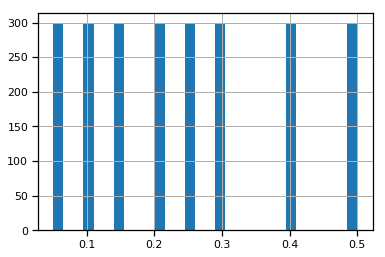

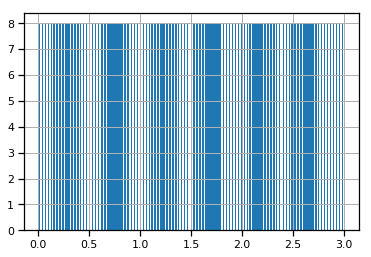

In [9]:
to_interpolate['EB_V'].hist(bins=30)
plt.figure()
to_interpolate['z'].hist(bins=500)

In [10]:
to_interpolate['EB_V'].min(), to_interpolate['EB_V'].max()

(0.05, 0.5)

In [11]:
to_interpolate['z'].min(), to_interpolate['z'].max()

(0.01, 2.99)

In [12]:
to_interpolate['WISE_1_scaled'] = to_interpolate['WISE_1'].apply(lambda x: x ** 4)  # to show the range better

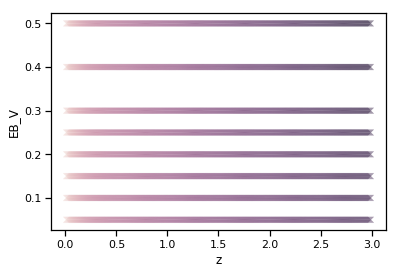

In [13]:
fig, ax = plt.subplots()
sns.scatterplot(data=to_interpolate, y='EB_V', x='z', hue='WISE_1_scaled', marker='x', alpha=0.5, legend=False, ax=ax)

With only 2 continuous model parameters, the model space is well-sampled - especially in redshift.

Let's interpolate:

In [14]:
interp_e_z = interpolate_templates(to_interpolate, 'WISE_1')

In [15]:
interp_e_z((0.2, 2.))

array(28.7661)

Seems like that works. Let's evaluate on a grid:

Text(0, 0.5, 'Interpolated W1 Mag')

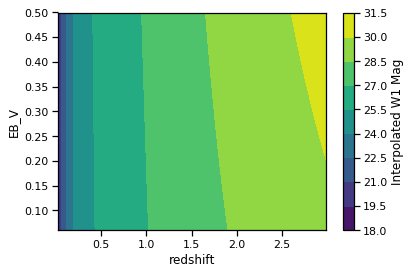

In [16]:
z_samples = np.linspace(0.02, 2.99, 100)  # cannot be on edge
eb_v_samples = np.linspace(0.06, 0.499, 100)  # cannot be on edge
z, eb_v = np.meshgrid(z_samples, eb_v_samples)
interpolated_grid = interp_e_z((eb_v, z))

fig, ax = plt.subplots()
contours = ax.contourf(z_samples, eb_v_samples, interpolated_grid)  # X, Y, Z format
ax.set_xlabel('redshift')
ax.set_ylabel('EB_V')
cbar = plt.colorbar(contours)
cbar.ax.set_ylabel('Interpolated W1 Mag')

Interpolation looks pretty good vs. what I would guess from the scatterplot above.

# Interpolate Templates into Continuous Variables

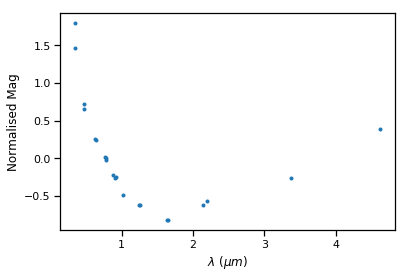

In [17]:
fig, ax = plt.subplots()
visualise_templates.visualise_mags(to_interpolate.iloc[0], ax)

What axis can we evaluate starforming models across?

In [18]:
starforming_models = starforming.query('EB_V == 0').query('z == 0')

In [19]:
len(starforming_models)

13

Plot each template, colored by the index of the template

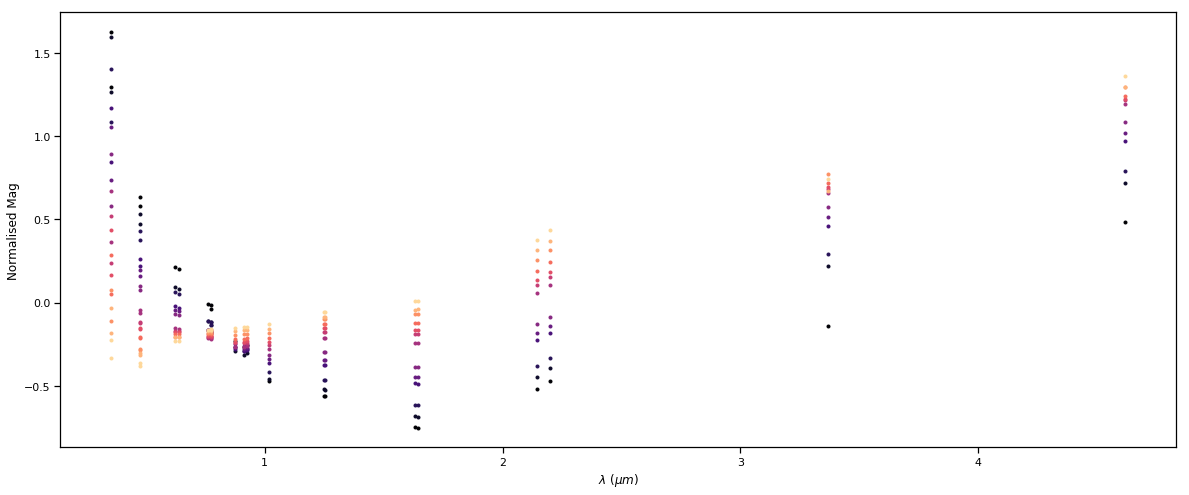

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))
_ = [visualise_templates.visualise_mags(starforming_models.iloc[n], ax, color=cm.magma(int(n * 255 / len(starforming_models) ))) for n in range(len(starforming_models))]

More orange colors are higher-indexed templates. Clearly, the templates are ordered. Let's call this ordering parameter 'lambda_gradient'

## Linear Interpolation of Lambda, EB_V, and z

If we add a dummy variable as a proxy for the template continuum, we can interpolate in exactly the same way as we did for EB_V and z

In [21]:
to_interpolate = starforming.query('z < 3.').query('WISE_1 > 15.').query('Ext_law == 1')  # now allowing all models

In [22]:
to_interpolate['lambda_gradient'] = to_interpolate['model'].astype(float)

In [23]:
to_interpolate['model'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])

In [24]:
interp_lambda_e_z = interpolate_templates(to_interpolate, 'WISE_1', var_cols=['lambda_gradient', 'EB_V', 'z'])

In [25]:
interp_lambda_e_z((1.01, 0.2, 2.))  # now interpolating in 3D

array(28.76698)

In [26]:
parameter_bounds = OrderedDict([
    ('lambda', (1.01, 12.99)),
    ('eb_v', (0.06, 0.49)),
    ('z', (0.05, 2.95))]
)

Text(0, 0.5, 'Interpolated W1 Mag')

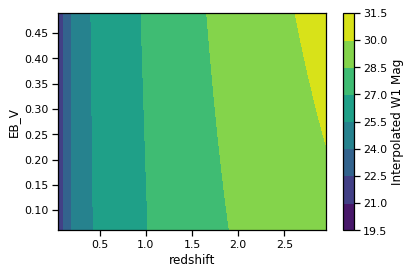

In [27]:
z_samples = np.linspace(parameter_bounds['z'][0], parameter_bounds['z'][1])  # cannot be on edge
eb_v_samples = np.linspace(parameter_bounds['eb_v'][0], parameter_bounds['eb_v'][1])  # cannot be on edge
z, eb_v = np.meshgrid(z_samples, eb_v_samples)

interpolated_grid = interp_lambda_e_z((1.001, eb_v, z))  # using model = 1

fig, ax = plt.subplots()
contours = ax.contourf(z_samples, eb_v_samples, interpolated_grid)  # X, Y, Z format
ax.set_xlabel('redshift')
ax.set_ylabel('EB_V')
cbar = plt.colorbar(contours)
cbar.ax.set_ylabel('Interpolated W1 Mag')

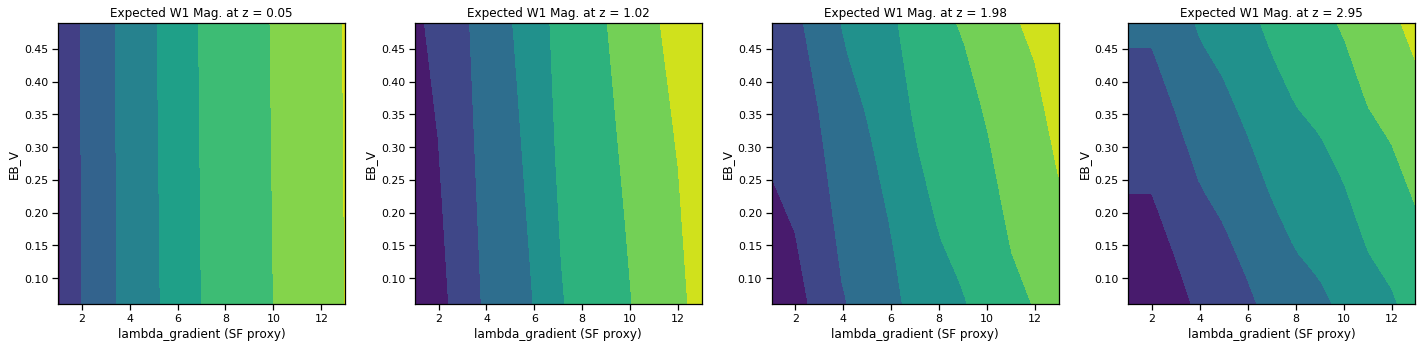

In [28]:
model_samples = np.linspace(parameter_bounds['lambda'][0], parameter_bounds['lambda'][1])
eb_v_samples = np.linspace(parameter_bounds['eb_v'][0], parameter_bounds['eb_v'][1])  # cannot be on edge
model, eb_v  = np.meshgrid(model_samples, eb_v_samples)

z_samples = np.linspace(parameter_bounds['z'][0], parameter_bounds['z'][1], 4)  # cannot be on edge

fig, axes = plt.subplots(ncols=4, figsize=(20, 5))
for n, z in enumerate(z_samples):
    ax = axes[n]
    interpolated_grid = interp_lambda_e_z((model, eb_v, z))  
    contours = ax.contourf(model_samples, eb_v_samples, interpolated_grid)  # X, Y, Z format
    ax.set_xlabel('lambda_gradient (SF proxy)')
    ax.set_ylabel('EB_V')
    ax.set_title('Expected W1 Mag. at z = {:.2f}'.format(z))
#    been hopingbeen hoping cbar = plt.colorbar(contours)
    cbar.ax.set_ylabel('Interpolated W1 Mag')
fig.tight_layout()

### Save interpolated model (including template proxy variable) along with associated bounds

In [55]:
model = InterpolatedModel('lambda_e_z', interp_lambda_e_z, parameter_bounds)

In [56]:
model_loc = '../data/interp_starforming_lambda_e_z.pickle'
model.save(model_loc)

In [57]:
loaded = pickle.load(open(model_loc, 'rb'))

In [58]:
loaded

InterpolatedModel "lambda_e_z", with bounds OrderedDict([('lambda', (1.01, 12.99)), ('eb_v', (0.06, 0.49)), ('z', (0.05, 2.95))])